In [ ]:
import requests
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arc


# Setup pitch and plot
from mplsoccer.pitch import Pitch, VerticalPitch

# username = "XXX"
# password = "XXX"


# from skillcorner.client import SkillcornerClient

# client = SkillcornerClient(username=username, password=password)


def time_to_seconds(time_str):
    if time_str is None:
        return 90 * 60  # 120 minutes = 7200 seconds
    h, m, s = map(int, time_str.split(":"))
    return h * 3600 + m * 60 + s

# 1.0 Extract the tracking data

In [6]:
####-----------------------------------------------------------------------------------
# If you're a skillcorner client and you know your match_id you can use the pyton client
###------------------------------------------------------------------------------------
# match_id=1886347
# client.save_match_tracking_data(match_id,
#                                 params={'data_version':3},
#                                 filepath=f'{match_id}_tracking_raw.jsonl')

####-----------------------------------------------------------------------------------
# If you've cloned the repo and are in your local machine
###------------------------------------------------------------------------------------
# match_id=1886347
# raw_data=pd.read_json(f'../data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl', lines=True)

####-----------------------------------------------------------------------------------
# If you're on a separate project/environemnt
###------------------------------------------------------------------------------------

matches_json_path = os.path.join(os.getcwd(), "data/matches.json")

with open(matches_json_path, "r") as f:
    matches_json = json.load(f)

match_id = matches_json[0]["id"]

# match_id = 1886347
# Construct the raw GitHub URL
tracking_data_github_url = f"https://media.githubusercontent.com/media/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_tracking_extrapolated.jsonl"  # Data is stored using GitLFS
raw_data = pd.read_json(tracking_data_github_url, lines=True)

# This is common
raw_df = pd.json_normalize(
    raw_data.to_dict("records"),
    "player_data",
    ["frame", "timestamp", "period", "possession", "ball_data"],
)

# Extract 'player_id' and 'group from the 'possession' dictionary
raw_df["possession_player_id"] = raw_df["possession"].apply(
    lambda x: x.get("player_id")
)
raw_df["possession_group"] = raw_df["possession"].apply(lambda x: x.get("group"))


# (Optional) Expand the ball_data with json_normalize
raw_df[["ball_x", "ball_y", "ball_z", "is_detected_ball"]] = pd.json_normalize(
    raw_df.ball_data
)


# (Optional) Drop the original 'possession' column if you no longer need it
raw_df = raw_df.drop(columns=["possession", "ball_data"])

# Add the match_id identifier to your dataframe
raw_df["match_id"] = match_id
tracking_df = raw_df.copy()
tracking_df.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,ball_y,ball_z,is_detected_ball,match_id
0,-38.16,1.51,51678,False,2510,2025-10-17,1.0,NaN,None,-0.46,-0.12,0.14,True,2017461
1,-20.78,3.31,51013,True,2510,2025-10-17,1.0,NaN,None,-0.46,-0.12,0.14,True,2017461
2,-20.93,14.81,51685,True,2510,2025-10-17,1.0,NaN,None,-0.46,-0.12,0.14,True,2017461
3,-21.03,-8.49,800322,True,2510,2025-10-17,1.0,NaN,None,-0.46,-0.12,0.14,True,2017461
4,-8.60,23.72,811820,True,2510,2025-10-17,1.0,NaN,None,-0.46,-0.12,0.14,True,2017461


Number of rows in tracking_df: 888888
How many different timestamps are when the ball is not detected: 8494


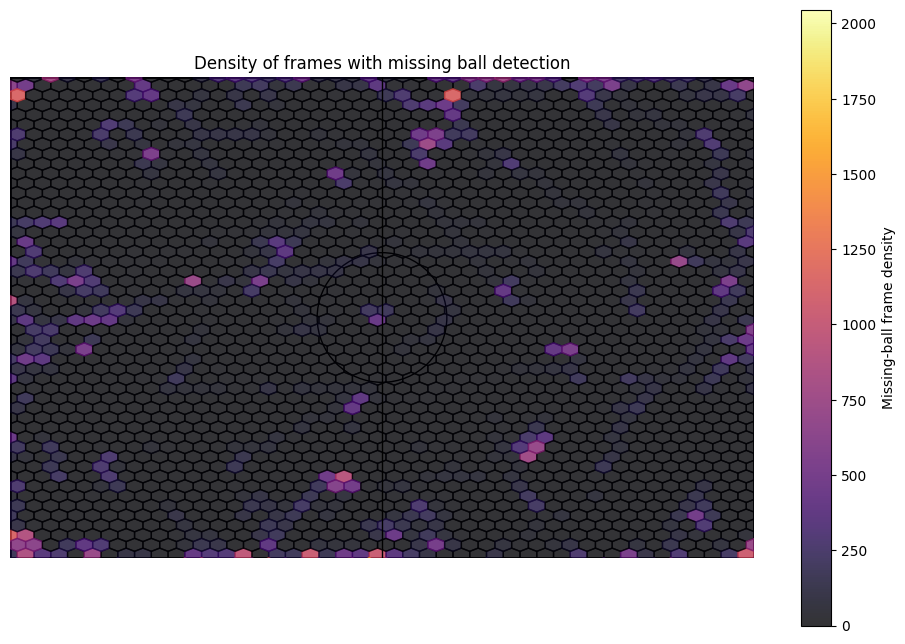

            count  duration_s
count  189.000000  189.000000
mean    45.126984    4.512698
min      7.000000    0.700000
25%     26.000000    2.600000
50%     37.000000    3.700000
75%     56.000000    5.600000
max    191.000000   19.100000
std     29.023922    2.902392


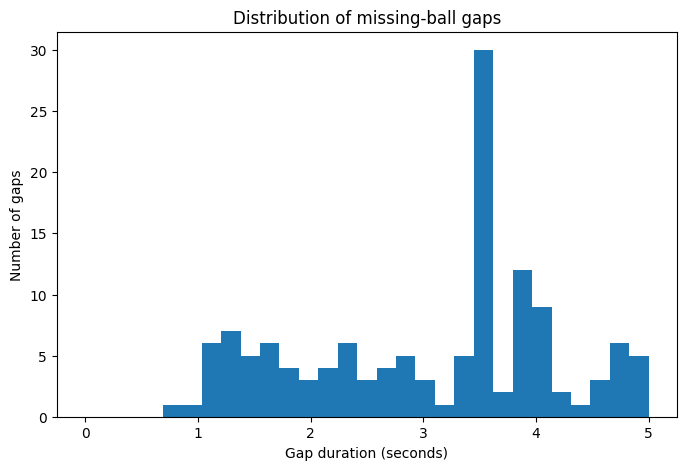

Analysis complete. Conclusion: Missing detection sometimes near corners and thats fine. Sparse in midfield. Uniformly  distributed which means the extrapolation model is stable and not location-dependent.
About gasps, dont need to worry. There are some gaps but most are short and we trust on the extrapolation model they use.


In [17]:
# SkillCorner says some data points are erroneous or the ball is not detected.
# Analyse when the ball is not detected and if there are any patterns or it would have a big influence on further analysis.

print(f"Number of rows in tracking_df: {len(tracking_df)}")
print(f"How many different timestamps are when the ball is not detected: {len(tracking_df[tracking_df['is_detected_ball'] == False]['timestamp'].unique())}")

ball_missing = tracking_df[tracking_df["is_detected_ball"] == False]

def draw_pitch(ax=None, pitch_length=105, pitch_width=68):
    if ax is None:
        ax = plt.gca()
    # Pitch outline
    ax.add_patch(Rectangle((-pitch_length/2, -pitch_width/2), pitch_length, pitch_width,
                           fill=False, lw=2))
    # Halfway line
    ax.plot([0,0], [-pitch_width/2, pitch_width/2], color='black', lw=1)
    # Center circle
    center_circle = plt.Circle((0,0), 9.15, color='black', fill=False, lw=1)
    ax.add_patch(center_circle)
    # Set limits and equal aspect
    ax.set_xlim(-pitch_length/2, pitch_length/2)
    ax.set_ylim(-pitch_width/2, pitch_width/2)
    ax.set_aspect('equal')
    ax.axis('off')
    return ax

plt.figure(figsize=(12,8))
ax = plt.gca()
draw_pitch(ax)

plt.hexbin(
    ball_missing["ball_x"],
    ball_missing["ball_y"],
    gridsize=50,
    cmap="inferno",
    alpha=0.8,
)
plt.title("Density of frames with missing ball detection")
plt.colorbar(label="Missing-ball frame density")
plt.show()

# Sort just in case
tracking_df_sorted = tracking_df.sort_values(["period", "timestamp"])

# Get distinct frame-level timestamps (drop player duplicates)
frame_df = tracking_df_sorted.drop_duplicates(["period", "timestamp"]).copy()  # 👈 explicit copy

# Boolean mask of missing ball frames
missing_mask = ~frame_df["is_detected_ball"]

# Find transitions between missing and detected segments
frame_df.loc[:, "missing_group"] = (missing_mask != missing_mask.shift()).cumsum()

# Keep only missing sequences
missing_segments = (
    frame_df[missing_mask]
    .groupby("missing_group")["timestamp"]
    .agg(["min", "max", "count"])
)
missing_segments["duration_s"] = missing_segments["count"] / 10.0  # 10 fps

# Describe
print(missing_segments.describe()[["count", "duration_s"]])

# Plot distribution of gap durations
plt.figure(figsize=(8,5))
plt.hist(missing_segments["duration_s"], bins=np.linspace(0, 5, 30))
plt.xlabel("Gap duration (seconds)")
plt.ylabel("Number of gaps")
plt.title("Distribution of missing-ball gaps")
plt.show()

print("Analysis complete. Conclusion: Missing detection sometimes near corners and thats fine. Sparse in midfield. Uniformly  distributed which means the extrapolation model is stable and not location-dependent.")
print("About gasps, dont need to worry. There are some gaps but most are short and we trust on the extrapolation model they use.")


# Congrats ! You have your (maybe) first tracking data frame

Now we need to get player information !

# 2.0 Extract meta data from matches

In [19]:
####-----------------------------------------------------------------------------------
# If you're a skillcorner client and you know your match_id you can use the python client
###------------------------------------------------------------------------------------
# match_id=1886347
# raw_match_data=client.get_match(match_id)


####-----------------------------------------------------------------------------------
# If you've cloned the repo and are in your local machine
###------------------------------------------------------------------------------------
# match_id = 1886347
# file_path = f'../data/matches/{match_id}/{match_id}_match.json'

# with open(file_path, 'r') as f:
#     raw_match_data = json.load(f)


####-----------------------------------------------------------------------------------
# If you're on a separate project/environment
###------------------------------------------------------------------------------------
# match_id = 1886347
meta_data_github_url = f"https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches/{match_id}/{match_id}_match.json"
# Read the JSON data as a JSON object
response = requests.get(meta_data_github_url)
raw_match_data = response.json()
print(f"Loaded match metadata for match_id: {match_id}")
print(f"Columns in match metadata: {list(raw_match_data.keys())}")


# The output has nested json elements. We process them
raw_match_df = pd.json_normalize(raw_match_data, max_level=2)
raw_match_df["home_team_side"] = raw_match_df["home_team_side"].astype(str)

players_df = pd.json_normalize(
    raw_match_df.to_dict("records"),
    record_path="players",
    meta=[
        "home_team_score",
        "away_team_score",
        "date_time",
        "home_team_side",
        "home_team.name",
        "home_team.id",
        "away_team.name",
        "away_team.id",
    ],  # data we keep
)


# Take only players who played and create their total time
players_df = players_df[
    ~((players_df.start_time.isna()) & (players_df.end_time.isna()))
]
players_df["total_time"] = players_df["end_time"].apply(time_to_seconds) - players_df[
    "start_time"
].apply(time_to_seconds)

# Create a flag for GK
players_df["is_gk"] = players_df["player_role.acronym"] == "GK"

# Add a flag if the given player is home or away
players_df["match_name"] = (
    players_df["home_team.name"] + " vs " + players_df["away_team.name"]
)


# Add a flag if the given player is home or away
players_df["home_away_player"] = np.where(
    players_df.team_id == players_df["home_team.id"], "Home", "Away"
)

# Create flag from player
players_df["team_name"] = np.where(
    players_df.team_id == players_df["home_team.id"],
    players_df["home_team.name"],
    players_df["away_team.name"],
)

# Figure out sides
players_df[["home_team_side_1st_half", "home_team_side_2nd_half"]] = (
    players_df["home_team_side"]
    .astype(str)
    .str.strip("[]")
    .str.replace("'", "")
    .str.split(", ", expand=True)
)
# Clean up sides
players_df["direction_player_1st_half"] = np.where(
    players_df.home_away_player == "Home",
    players_df.home_team_side_1st_half,
    players_df.home_team_side_2nd_half,
)
players_df["direction_player_2nd_half"] = np.where(
    players_df.home_away_player == "Home",
    players_df.home_team_side_2nd_half,
    players_df.home_team_side_1st_half,
)


# Clean up and keep the columns that we want to keep about

columns_to_keep = [
    "start_time",
    "end_time",
    "match_name",
    "date_time",
    "home_team.name",
    "away_team.name",
    "id",
    "short_name",
    "number",
    "team_id",
    "team_name",
    "player_role.position_group",
    "total_time",
    "player_role.name",
    "player_role.acronym",
    "is_gk",
    "direction_player_1st_half",
    "direction_player_2nd_half",
]
players_df = players_df[columns_to_keep]
players_df.head()

Loaded match metadata for match_id: 2017461
Columns in match metadata: ['id', 'home_team_score', 'away_team_score', 'date_time', 'stadium', 'home_team', 'home_team_kit', 'away_team', 'away_team_kit', 'home_team_coach', 'away_team_coach', 'home_team_playing_time', 'away_team_playing_time', 'competition_edition', 'match_periods', 'competition_round', 'referees', 'players', 'status', 'home_team_side', 'ball', 'pitch_length', 'pitch_width']


,start_time,end_time,match_name,date_time,home_team.name,away_team.name,id,short_name,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,01:23:12,None,Melbourne Victory Football Club vs Auckland FC,2025-05-17T09:35:00Z,Melbourne Victory Football Club,Auckland FC,795521,A. Badolato,23,868,Melbourne Victory Football Club,Wide Attacker,408,Right Winger,RW,False,left_to_right,right_to_left
1,01:02:21,None,Melbourne Victory Football Club vs Auckland FC,2025-05-17T09:35:00Z,Melbourne Victory Football Club,Auckland FC,965685,L. Gillion,14,4177,Auckland FC,Wide Attacker,1659,Left Winger,LW,False,right_to_left,left_to_right
2,01:14:54,None,Melbourne Victory Football Club vs Auckland FC,2025-05-17T09:35:00Z,Melbourne Victory Football Club,Auckland FC,31147,T. Smith,5,4177,Auckland FC,Central Defender,906,Center Back,CB,False,right_to_left,left_to_right
3,00:00:00,01:23:12,Melbourne Victory Football Club vs Auckland FC,2025-05-17T09:35:00Z,Melbourne Victory Football Club,Auckland FC,50955,N. Velupillay,17,868,Melbourne Victory Football Club,Wide Attacker,4992,Left Winger,LW,False,left_to_right,right_to_left
4,00:00:00,01:19:39,Melbourne Victory Football Club vs Auckland FC,2025-05-17T09:35:00Z,Melbourne Victory Football Club,Auckland FC,23418,F. Gallegos,28,4177,Auckland FC,Midfield,4779,Left Midfield,LM,False,right_to_left,left_to_right


# We successfully prepared all the meta data we need for our tracking data

# 3.0 Merge Dataframes

In [20]:
# Merging datasets
enriched_tracking_data = tracking_df.merge(
    players_df, left_on=["player_id"], right_on=["id"]
)
enriched_tracking_data.head()

,x,y,player_id,is_detected,frame,timestamp,period,possession_player_id,possession_group,ball_x,...,number,team_id,team_name,player_role.position_group,total_time,player_role.name,player_role.acronym,is_gk,direction_player_1st_half,direction_player_2nd_half
0,-38.16,1.51,51678,False,2510,2025-10-17,1.0,NaN,None,-0.46,...,25,868,Melbourne Victory Football Club,Other,5400,Goalkeeper,GK,True,left_to_right,right_to_left
1,-20.78,3.31,51013,True,2510,2025-10-17,1.0,NaN,None,-0.46,...,5,868,Melbourne Victory Football Club,Central Defender,3469,Right Center Back,RCB,False,left_to_right,right_to_left
2,-20.93,14.81,51685,True,2510,2025-10-17,1.0,NaN,None,-0.46,...,4,868,Melbourne Victory Football Club,Central Defender,5400,Left Center Back,LCB,False,left_to_right,right_to_left
3,-21.03,-8.49,800322,True,2510,2025-10-17,1.0,NaN,None,-0.46,...,16,868,Melbourne Victory Football Club,Full Back,5400,Right Back,RB,False,left_to_right,right_to_left
4,-8.60,23.72,811820,True,2510,2025-10-17,1.0,NaN,None,-0.46,...,28,868,Melbourne Victory Football Club,Full Back,5400,Left Back,LB,False,left_to_right,right_to_left


# Now our data is completed

---

# 4.0 Let's see an example of how to visualize average positions, accounting for play direction

In [21]:
# Filtering for frames with a team in possession
filtered_df = enriched_tracking_data[
    enriched_tracking_data["possession_group"].notnull()
].copy()


# We basically want to convert the X and Y to make sure we're always visualizing left to right. A player's XY will depend on the half so the straight average doesn't work

filtered_df["direction_player"] = np.where(
    filtered_df["period"] == 1,
    filtered_df["direction_player_1st_half"],
    filtered_df["direction_player_2nd_half"],
)
filtered_df["x"] = np.where(
    filtered_df["direction_player"] == "right_to_left",
    -filtered_df["x"],
    filtered_df["x"],
)  # Convert X
filtered_df["y"] = np.where(
    filtered_df["direction_player"] == "right_to_left",
    -filtered_df["y"],
    filtered_df["y"],
)  # Convert Y

# Create some flags in case we need them later
filtered_df["possession_team_name"] = np.where(
    filtered_df["possession_group"] == "home team",
    filtered_df["home_team.name"],
    filtered_df["away_team.name"],
)
filtered_df["possession_flag"] = np.where(
    filtered_df["possession_team_name"] == filtered_df["team_name"], "IP", "OOP"
)


# At this point all of our players have their X and Y adjusted from left to right , so we can aggregate for across the game

aggregated_df = (
    filtered_df.groupby(
        [
            "player_id",
            "possession_group",
            "team_name",
            "possession_team_name",
            "possession_flag",  # This will allow us to check the position of the player when the team is in or out of possession
            "start_time",  # With this we can filter in or out the players that came on as subs
            "number",
            "is_gk",
        ]
    )[["x", "y"]]
    .mean()
    .reset_index()
)

aggregated_df.sort_values(["possession_flag", "team_name"])

# We have an aggregate by possession type !

,player_id,possession_group,team_name,possession_team_name,possession_flag,start_time,number,is_gk,x,y
0,4322,away team,Auckland FC,Auckland FC,IP,00:00:00,2,False,-6.972742,-17.789153
6,14736,away team,Auckland FC,Auckland FC,IP,00:00:00,6,False,-1.869197,-5.036363
8,23418,away team,Auckland FC,Auckland FC,IP,00:00:00,28,False,-4.862500,1.742946
12,31147,away team,Auckland FC,Auckland FC,IP,01:14:54,5,False,-15.974297,-3.087785
14,33697,away team,Auckland FC,Auckland FC,IP,00:00:00,4,False,-12.566094,4.589294
...,...,...,...,...,...,...,...,...,...,...
46,159688,away team,Melbourne Victory Football Club,Auckland FC,OOP,00:00:00,14,False,-7.532112,4.646465
54,745320,away team,Melbourne Victory Football Club,Auckland FC,OOP,01:09:04,11,False,7.214267,10.598787
56,795521,away team,Melbourne Victory Football Club,Auckland FC,OOP,01:23:12,23,False,-2.752054,-0.281760
58,800322,away team,Melbourne Victory Football Club,Auckland FC,OOP,00:00:00,16,False,-11.774355,-12.194109


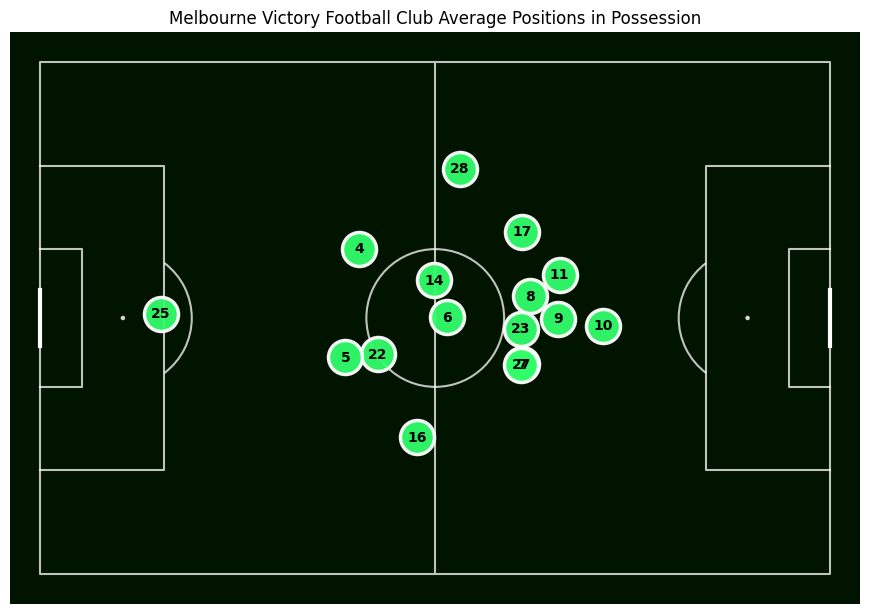

In [22]:
# Visualizing the data on a pitch

pitch = Pitch(
    pitch_type="skillcorner",
    line_alpha=0.75,
    pitch_length=105,
    pitch_width=68,
    pitch_color="#001400",
    line_color="white",
    linewidth=1.5,
)
fig, ax = pitch.grid(figheight=8, endnote_height=0, title_height=0)


# What to visualize
possession = "IP"  # or 'OOP'
team = aggregated_df.team_name.unique().tolist()[
    1
]  # Pick one team, you can use the name directly

viz_ip = aggregated_df[
    (aggregated_df["possession_flag"] == possession)
    & (aggregated_df["team_name"] == team)
].reset_index(drop=True)


ax.scatter(
    viz_ip["x"],
    viz_ip["y"],
    c="#32FE6B",
    alpha=0.95,
    s=600,
    edgecolors="white",
    linewidths=2.5,
    zorder=10,
    label="team",
)


# Annotate player numbers
for i, row in viz_ip.iterrows():
    ax.text(
        row["x"],
        row["y"],
        str(row["number"]),
        color="black",
        fontweight="bold",
        fontsize=10,
        ha="center",
        va="center",
        zorder=16,
    )

ax.set_title(f"{team} Average Positions in Possession")

fig.savefig("my_visualised_tracking_data.png", dpi=300, format="png")

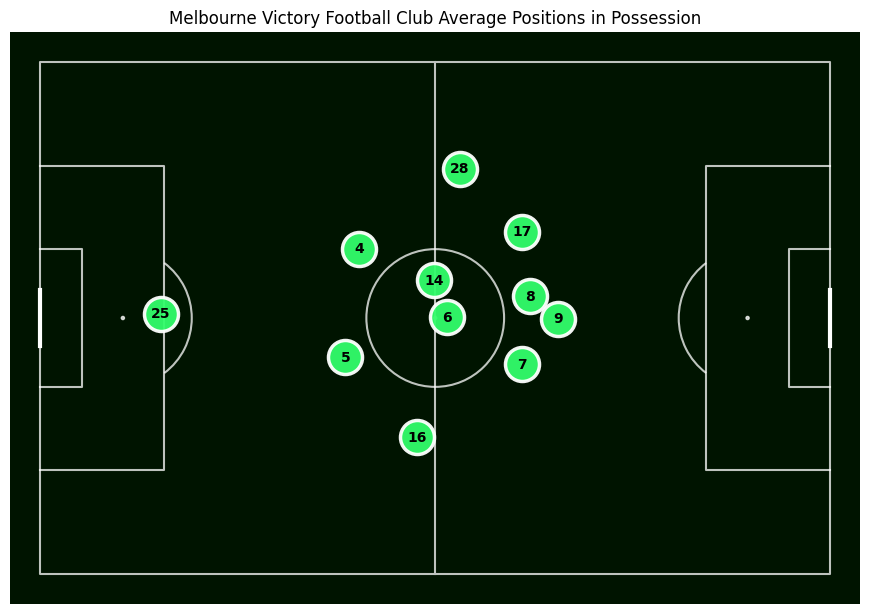

In [12]:
# Starters Onlyu

pitch = Pitch(
    pitch_type="skillcorner",
    line_alpha=0.75,
    pitch_length=105,
    pitch_width=68,
    pitch_color="#001400",
    line_color="white",
    linewidth=1.5,
)
fig, ax = pitch.grid(figheight=8, endnote_height=0, title_height=0)


# What to visualize
possession = "IP"  # or 'OOP'
team = aggregated_df.team_name.unique().tolist()[
    1
]  # Pick one team, you can use the name directly

viz_ip = aggregated_df[
    (aggregated_df["possession_flag"] == possession)
    & (aggregated_df["team_name"] == team)
    & (aggregated_df["start_time"] == "00:00:00")
].reset_index(drop=True)


ax.scatter(
    viz_ip["x"],
    viz_ip["y"],
    c="#32FE6B",
    alpha=0.95,
    s=600,
    edgecolors="white",
    linewidths=2.5,
    zorder=10,
    label="team",
)


# Annotate player numbers
for i, row in viz_ip.iterrows():
    ax.text(
        row["x"],
        row["y"],
        str(row["number"]),
        color="black",
        fontweight="bold",
        fontsize=10,
        ha="center",
        va="center",
        zorder=16,
    )

ax.set_title(f"{team} Average Positions in Possession")

fig.savefig("my_visualised_tracking_data_starters.png", dpi=300, format="png")